reference: https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import re
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path_to_dataset = '/content/drive/My Drive/chatbot/'
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'All-seasons.csv')

In [0]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"can't", "can not", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [0]:
def load_conversations():
  # dictionary of line id to text
  questions = []
  answers = []
  data = pd.read_csv(path_to_movie_conversations)

  for i in range(0, data.shape[0] - 1):
    if data.iloc[i + 1][2] == 'Stan':
        questions.append(preprocess_sentence(data.iloc[i][3]))
        answers.append(preprocess_sentence(data.iloc[i + 1][3]))
      
  return questions, answers


questions, answers = load_conversations()

In [9]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: ha ! i knew it !
Sample answer: knew what ?


In [0]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [0]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 286, 2, 286, 2, 144, 382, 194, 2, 42, 4, 38, 104, 3, 11, 798, 31, 1170, 2214, 1]


In [0]:
# Maximum sentence length
MAX_LENGTH = 30
MIN_LENGTH = 1


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH and len(sentence1) > MIN_LENGTH and len(sentence2) > MIN_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [12]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 7288
Number of samples: 6164


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 30), dec_inputs: (None, 29)}, {outputs: (None, 29)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [0]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [0]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [0]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [0]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [0]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [0]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [0]:

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [0]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

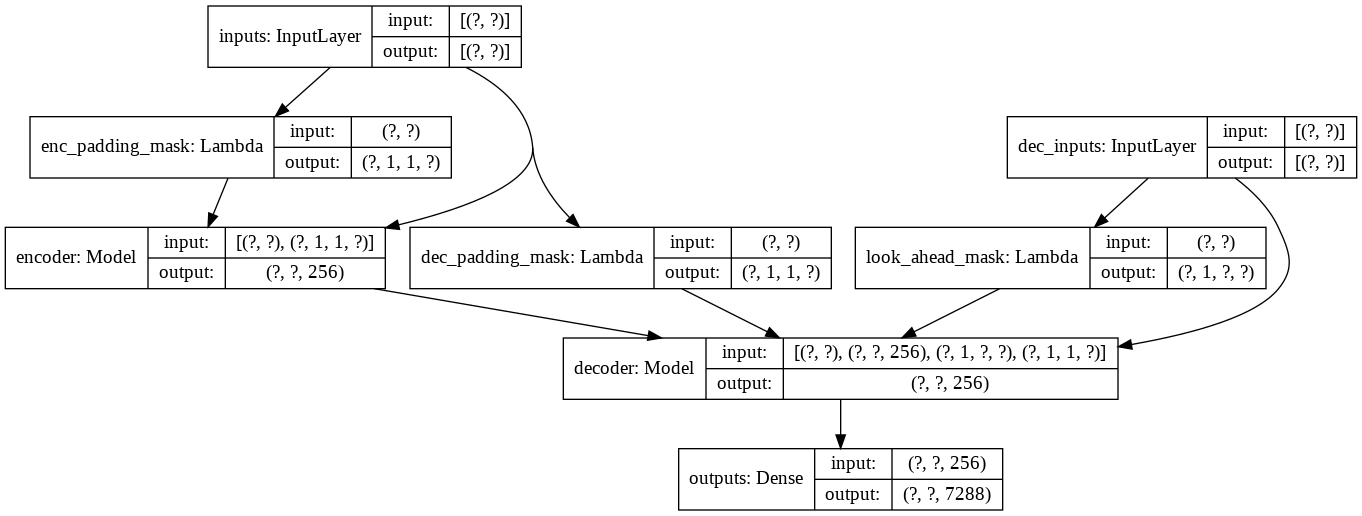

In [25]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

tf.keras.utils.plot_model(
    model, to_file='transformer.png', show_shapes=True)

In [0]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
    config = {'d_model': self.d_model,'warmup_steps': self.warmup_steps}
    return config

Text(0.5, 0, 'Train Step')

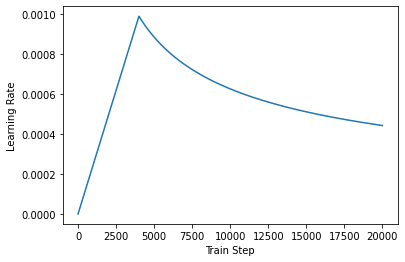

In [30]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
folderpath='/content/drive/My Drive/chatbot/'
filepath=folderpath+'model7-{epoch:02d}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

history = model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
EPOCHS = 50
ini_epochs= 0

model.fit(dataset, epochs=EPOCHS,initial_epoch = ini_epochs,callbacks=[cp_callback])

Epoch 1/50
97/97 [==============================] - ETA: 0s - loss: 3.3090 - accuracy: 0.0229
Epoch 00001: saving model to /content/drive/My Drive/chatbot/model7-01.hdf5
97/97 [==============================] - 10s 103ms/step - loss: 3.3090 - accuracy: 0.0229
Epoch 2/50
97/97 [==============================] - ETA: 0s - loss: 2.9904 - accuracy: 0.0366
Epoch 00002: saving model to /content/drive/My Drive/chatbot/model7-02.hdf5
97/97 [==============================] - 10s 103ms/step - loss: 2.9904 - accuracy: 0.0366
Epoch 3/50
97/97 [==============================] - ETA: 0s - loss: 2.5421 - accuracy: 0.0547
Epoch 00003: saving model to /content/drive/My Drive/chatbot/model7-03.hdf5
97/97 [==============================] - 10s 104ms/step - loss: 2.5421 - accuracy: 0.0547
Epoch 4/50
97/97 [==============================] - ETA: 0s - loss: 2.1919 - accuracy: 0.0660
Epoch 00004: saving model to /content/drive/My Drive/chatbot/model7-04.hdf5
97/97 [==============================] - 10s 104ms

In [55]:
EPOCHS = 100
ini_epochs= 50

model.fit(dataset, epochs=EPOCHS,initial_epoch = ini_epochs,callbacks=[cp_callback])

Epoch 51/100
97/97 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.3661
Epoch 00051: saving model to /content/drive/My Drive/chatbot/model7-51.hdf5
97/97 [==============================] - 10s 102ms/step - loss: 0.0718 - accuracy: 0.3661
Epoch 52/100
97/97 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.3678
Epoch 00052: saving model to /content/drive/My Drive/chatbot/model7-52.hdf5
97/97 [==============================] - 10s 103ms/step - loss: 0.0667 - accuracy: 0.3678
Epoch 53/100
97/97 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.3684
Epoch 00053: saving model to /content/drive/My Drive/chatbot/model7-53.hdf5
97/97 [==============================] - 10s 103ms/step - loss: 0.0644 - accuracy: 0.3684
Epoch 54/100
97/97 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.3687
Epoch 00054: saving model to /content/drive/My Drive/chatbot/model7-54.hdf5
97/97 [==============================] - 1

In [0]:
model.load_weights('/content/drive/My Drive/chatbot/model7-61.hdf5')

In [0]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [141]:
output = predict('hi stan')

Input: hi stan
Output: hey dad .


In [142]:
output = predict('What are you doing here?')

Input: What are you doing here?
Output: please , ih ih , it wo not take long .


In [143]:
output = predict('Where have you been?')

Input: Where have you been?
Output: dude , my mom s having her monthly visitor .


In [144]:
output = predict("stan")

Input: stan
Output: kyle ? dude , you did make a deal ?


In [159]:
output = predict("tell me something about you.")

Input: tell me something about you.
Output: uh , sure , and we will also try to free hat .


In [145]:
output = predict("how old are you?")

Input: how old are you?
Output: why does that matter ?


In [0]:
import random
def beam_search(sentence,beam_size = 3,k=6):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  output = tf.expand_dims(START_TOKEN, 0)

  sequences = [[output, 1.0, False]]
  for j in range(MAX_LENGTH):
   all_candidates = list()
   for i in range(min(k,len(sequences))):
     seq, score,done = sequences[i]
     if not done:
       predictions = model(inputs=[sentence, seq], training=False)
       predictions = predictions[:, -1:, :]
       predictions =tf.nn.softmax(predictions, axis=-1, name=None)
       for _ in range(beam_size):
        prob = tf.squeeze(tf.math.reduce_max(predictions, axis=-1, keepdims=False, name=None))
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        output = tf.concat([seq, predicted_id], axis=-1)
        mask = tf.greater_equal(predictions,prob )
        zeros = tf.zeros_like(predictions)
        predictions = tf.where(mask, zeros, predictions)
        penalty = ((5.0 + j) / 6.0) ** 0.4
        score *= penalty
        beam_score = score + -tf.math.log(prob)
        if tf.equal(predicted_id, END_TOKEN[0]):
          done=True
          
        penalty = ((5.0 + (j + 1)) / 6.0) ** 0.4
        beam_score /=penalty
        candidate = [output, beam_score,done]
        all_candidates.append(candidate)
     else:
       all_candidates.append(sequences[i])
     

   ordered = sorted(all_candidates, key=lambda tup:tup[1])
   sequences = ordered

  
  
  res,_,_ = sequences[0]
  prediction = tf.squeeze(res)
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  #print('search beam: {}'.format(predicted_sentence))
    
  return predicted_sentence

In [147]:
beam_search('hi stan')

'hey dad .'

In [148]:
beam_search('Where have you been?')

'dude , my mom s having her monthly visitor .'

In [149]:
beam_search("what are you doing here?")

'please , ih ih , it wo not take long .'

In [150]:
beam_search("how old are you?")

'why does that matter ?'

In [151]:
beam_search("i do not get it")

'me neither .'

In [152]:
beam_search("guys, can i talk to you")

'what is the matter ?'

In [153]:
beam_search("i am the vice president")

'i know .'

In [157]:
beam_search("tell me something about you.")

'there s nothing about liberals or conservatives !'

In [156]:
beam_search("stan")

'dude , you did make a deal . . .'